## Installing Transformers and Sentencepiece

In [ ]:
#install transformers 
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.1 MB/s 
     |████████████████████████████████| 101 kB 13.6 MB/s 
     |████████████████████████████████| 596 kB 66.0 MB/s 
     |████████████████████████████████| 6.6 MB 59.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 29.9 MB/s 


## Necessary imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup, get_scheduler
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import random
from tqdm.auto import tqdm

#Import Dataset

In [ ]:
mixed = pd.read_csv("/content/mixed_dataset.csv")

## 1.2 - Visualizing the data of Dataset

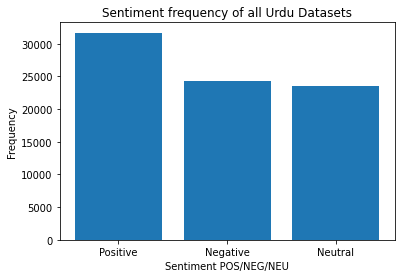

Positive 31677, Negative 24307, Neutral 23570


In [ ]:
y = list(mixed["Sentiment"].value_counts()) # getting frequency of all the 2 sentiments
plt.plot()
plt.bar(["Positive", "Negative", "Neutral"], y) # plottign frequency against labels in a bar chart
plt.xlabel("Sentiment POS/NEG/NEU")
plt.ylabel("Frequency")
plt.title("Sentiment frequency of all Urdu Datasets")
plt.show()

print("Positive {}, Negative {}, Neutral {}".format(y[0], y[1], y[2]))

## Importing Tokenizer

In [ ]:
# Download the tokenizer for the XLM-Robert `base` model.
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

## Sample tokenization of text (and checking data)

In [ ]:
#xlmr_tokenizer creates tokens based on subword
print("sample text = ", mixed.Text[1])
tokens = xlmr_tokenizer.tokenize(mixed.Text[1])
print("XLMR Roberta covert sample text into following tokens \n ", tokens)

sample text =  aram sy pocket may aa jta hai aur quality b achi hai
XLMR Roberta covert sample text into following tokens 
  ['▁a', 'ram', '▁sy', '▁pocket', '▁may', '▁a', 'a', '▁j', 'ta', '▁hai', '▁aur', '▁quality', '▁b', '▁a', 'chi', '▁hai']


In [ ]:
#some samples from data frame
print(mixed.Text[1])
print(mixed.Text[2])
print(mixed.Text[3])

aram sy pocket may aa jta hai aur quality b achi hai
sb sy achi chez apki customer service bhot achi hai aur products b orignal hai
back cover acha hai sai cuts hai aur soft b hai kaafi acha hai lakin protector chota hai size may khaas tor b width may lakin touch sai kaam kar rha hai isi hi tarha sensor b sb kuch thek hai aur combination b acha hai


In [ ]:
#checking the sentiment values 
#later on we will convert them into categorie i.e, integers
mixed['Sentiment']

0        0
1        0
2        0
3        0
4        1
        ..
79549    2
79550    2
79551    2
79552    0
79553    2
Name: Sentiment, Length: 79554, dtype: int64

In [ ]:
#accessing the sentiments for first few samples 
print(mixed.at[0,'Sentiment'])
print(mixed.at[1,'Sentiment'])
print(mixed.at[2,'Sentiment'])

0
0
0


## ***Encoding all samples while varying the max_length hyperparameter***

## 1. First run:
    - Hyperparameters:
        - max_length = 50
        - epochs = 5
        - batch_size = 16

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in mixed.index:
  text = mixed.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 50,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(mixed.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=16

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-6,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 5
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/22375 [00:00<?, ?it/s]

Epoch: 1
Epoch:  5
XLMR - validation accuracy  0.669683257918552
------------------------------------ 
Epoch: 2
Epoch:  5
XLMR - validation accuracy  0.6909250879839115
------------------------------------ 
Epoch: 3
Epoch:  5
XLMR - validation accuracy  0.7024886877828054
------------------------------------ 
Epoch: 4
Epoch:  5
XLMR - validation accuracy  0.7077677224736049
------------------------------------ 
Epoch: 5
Epoch:  5
XLMR - validation accuracy  0.7097787833081951
------------------------------------ 


## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.7097787833081951


## 2. Second run:
    - Hyperparameters:
        - max_length = 50
        - epochs = 30
        - batch_size = 16
        - learning_rate = 2e-5

In [ ]:
labels_ur = []
input_ids_ur = []
attn_masks_ur= []

print("Encoding all Examples in the dataset \n" )

for ind in mixed.index:
  text = mixed.Text[ind]
  #convert sentence pairs to input ids, with attention masks
  
  encoded_dict = xlmr_tokenizer.encode_plus(text,max_length = 50,  
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors = 'pt')
                                      
  

  
  input_ids_ur.append(encoded_dict['input_ids'])
  attn_masks_ur.append(encoded_dict['attention_mask'])
  #print(ex['label'].numpy)
  #we are converting the data into labels
  labels_ur.append(mixed.at[ind,'Sentiment'].astype(np.int64))
  
  #convert each python list of tensor to 2D tensor Matrix
input_ids_ur = torch.cat(input_ids_ur,dim=0)
attn_masks_ur = torch.cat(attn_masks_ur,dim=0)

#cast the labels into tensors
labels_ur = torch.tensor(labels_ur)
#print(len(labels_ur))

#combine the trainign inputs to tensorDatasets
dataset = TensorDataset(input_ids_ur,attn_masks_ur, labels_ur)

 #create a 90-10 train validation split
train_size = int(0.9*(len(dataset)))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset,[train_size, val_size])

batch_size=16

train_dataloader = DataLoader(train_dataset,
                          sampler=RandomSampler(train_dataset),
                          batch_size = batch_size)


validation_dataloader = DataLoader(val_dataset,
                          sampler=RandomSampler(val_dataset),
                          batch_size = batch_size)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",num_labels=3)

print("Loading model to GPU")
#connect to GPU
device = torch.device('cuda')
#report the GPu which is granted 
print('GPU:',torch.cuda.get_device_name(0))
#copy the initial model with weights to GPU
desc = xlmr_model.to(device)
print("Done")

optimizer  = AdamW(xlmr_model.parameters(),
                   lr = 2e-5,# learning rate
                   eps=1e-8 # args.adma_epsilon
                   )

#number of training epochs
epochs = 30
#total no of training steps is [number of batches]*[number of epoches]
total_steps = len(train_dataloader)*epochs

#create the learning rate scheduler 
scheduler  =  get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

progress_bar = tqdm(range(total_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0,epochs):
  #training
  print("Epoch:",epoch_i+1)
  total_train_loss = 0
  xlmr_model.train()
  
  #For each batch of train_data
  for step, batch in enumerate(train_dataloader):
    #progress update 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)
    xlmr_model.zero_grad()
    outputs =xlmr_model(b_input_ids,attention_mask = b_input_mask,labels=b_lables)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  
  #put the model in evaluation mode
  xlmr_model.eval()
  model_predictions=[]
  true_labels=[]

  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_lables = batch[2].to(device)

      with torch.no_grad():
        outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
      
      logits = outputs.logits
      logits=logits.detach().cpu().numpy()
      label_ids = b_lables.to('cpu').numpy()
      predictions = np.argmax(logits, axis = -1)
      model_predictions.append(logits)
      true_labels.append(label_ids)
  
  flat_predictions = np.concatenate(model_predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()
  accuracy = (predicted_labels==flat_true_labels).mean()
  
  print("Epoch: ", epochs)
  print('XLMR - validation accuracy ', accuracy)
  print("------------------------------------ ")

Encoding all Examples in the dataset 



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Loading model to GPU
GPU: Tesla T4
Done


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/22375 [00:00<?, ?it/s]

Epoch: 1
Epoch:  5
XLMR - validation accuracy  0.7163147310206134
------------------------------------ 
Epoch: 2
Epoch:  5
XLMR - validation accuracy  0.7450980392156863
------------------------------------ 
Epoch: 3
Epoch:  5
XLMR - validation accuracy  0.7546505781799899
------------------------------------ 
Epoch: 4
Epoch:  5
XLMR - validation accuracy  0.755656108597285
------------------------------------ 
Epoch: 5
Epoch:  5
XLMR - validation accuracy  0.7528908999497235
------------------------------------ 


## Evaluating the trained Model

In [ ]:
xlmr_model.eval()
model_predictions=[]
true_labels=[]
for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_lables = batch[2].to(device)

    with torch.no_grad():
      outputs = xlmr_model(b_input_ids,attention_mask = b_input_mask)
    logits = outputs.logits
    logits=logits.detach().cpu().numpy()
    label_ids = b_lables.to('cpu').numpy()
    predictions = np.argmax(logits, axis = -1)
    #print(b_lables)
    #print(predictions)
    #print("\n -------------------------- \n")
    model_predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
#combine the results across all batches
#predictions
flat_predictions = np.concatenate(model_predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

##for sample pick the label
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# the number of correct predictions to get our accuracy
accuracy = (predicted_labels==flat_true_labels).mean()
print('XLMR- prediction accuracy',accuracy)

XLMR- prediction accuracy 0.7528908999497235
